# Introduction
Xây dựng model YOLO cho bài toán Object Detection: ta sẽ xây dựng từ bài toán Classification, sau đó thêm vào task Localization và cuối cùng là Object Detection (YOLO)

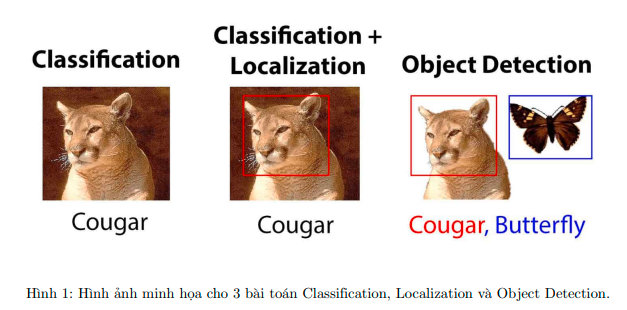

* **Classification** chỉ đơn giản là phân loại một object trong ảnh
* **Localization** không chỉ phân loại mà còn xác định vị trí của object đó bằng bounding box
* **Object Detection** kết hợp cả hai yếu tố này để phát hiện và định vị nhiều object trong một hình ảnh

# Classification (1 object trong ảnh)
Mục tiêu của bài toán này là phân loại hình ảnh chứa một object duy nhất thuộc về một trong hai class: cat (mèo) hoặc dog (chó).

## Import và tải thư viện
Để bắt đầu, chúng ta cần import các thư viện cần thiết và tải xuống bộ dữ liệu. Bộ dữ liệu này bao gồm các hình ảnh của mèo và chó, được sử dụng rộng rãi trong các bài toán Image Classification và Object Detection. Việc sử dụng bộ dữ liệu từ kagglehub giúp chúng ta dễ dàng quản lý và truy cập dữ liệu một cách hiệu quả.

In [1]:
import kagglehub

# Download the latest dataset version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir)


100%|██████████| 1.03G/1.03G [00:50<00:00, 21.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

## Định Nghĩa Class Dataset
Trong class ImageDataset, chúng ta thực hiện các bước sau:
* Khởi tạo: Xác định thư mục chứa annotations và hình ảnh, cũng như các biến đổi dữ liệu nếu có.
* Lọc dữ liệu: Loại bỏ những hình ảnh chứa nhiều hơn một object để đảm bảo tính nhất quán của bài toán Classification.
* Đếm object: Đếm số lượng object trong mỗi hình ảnh dựa trên các annotations.
* Lấy mẫu: Định nghĩa method `__getitem__` để truy xuất hình ảnh và nhãn tương ứng.
* Phân tích annotations: Chuyển đổi nhãn văn bản thành số để dễ dàng xử lý trong mô hình.

In [3]:
# Dataset Class
class ImageDataset(Dataset):
  def __init__(self, annotations_dir, image_dir, transform = None):
    self.annotations_dir = annotations_dir
    self.image_dir = image_dir
    self.transform = transform
    self.image_files = self.filter_images_with_multiple_objects()

  def filter_images_with_multiple_objects(self):
    valid_image_files = []
    for f in os.listdir(self.image_dir):
      if os.path.isfile(os.path.join(self.image_dir, f)):
        img_name = f
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        if self.count_objects_in_annotation(annotation_path) <= 1:
          valid_image_files.append(img_name)
        else:
          print(f" Image { img_name } has multiple objects and will be excluded from the dataset")
    return valid_image_files

  def count_objects_in_annotation(self, annotation_path):
    try:
      tree = ET.parse(annotation_path)
      root = tree.getroot()
      count = 0
      for obj in root.findall("object"):
        count += 1
      return count
    except FileNotFoundError:
      return 0

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    # Image path
    img_name = self.image_files[idx]
    img_path = os.path.join(self.image_dir, img_name)

    # Load image
    image = Image.open(img_path).convert("RGB")

    # Annotation path
    annotation_name = os.path.splitext(img_name)[0] + ".xml"
    annotation_path = os.path.join(self.annotations_dir, annotation_name)

    # Parse annotation
    label = self.parse_annotation(annotation_path)

    if self.transform:
      image = self.transform(image)
    return image, label

  def parse_annotation(self, annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    label = None
    for obj in root.findall("object"):
      name = obj.find("name").text
      if (label is None) : # Take the first label for now . We are working with 1 label per image
        label = name

    # Convert label to numerical representation (0 for cat , 1 for dog)
    label_num = 0 if label == "cat" else 1 if label == "dog" else -1

    return label_num

## Phân Tích và Chuẩn Bị Dữ Liệu
Sau khi định nghĩa class dataset, chúng ta tiến hành phân tích và chuẩn bị dữ liệu.

In [4]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

## Chuẩn Bị và Split Dữ Liệu
Chúng ta sẽ áp dụng các biến đổi (transforms) cho dữ liệu hình ảnh và chia tách dữ liệu thành tập training (train set) và tập testing (test set).


In [5]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485 , 0.456 , 0.406], std=[0.229 , 0.224 , 0.225])
    ])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform = transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform = transform )

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle = False)

 Image Cats_Test736.png has multiple objects and will be excluded from the dataset
 Image Cats_Test736.png has multiple objects and will be excluded from the dataset


## Xây Dựng Model
Chúng ta sẽ sử dụng model ResNet18 và finetune để phù hợp với bài toán classification của chúng ta.

In [6]:
# Model
model = models.resnet18(weights = ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 classes : cat and dog

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training loop
Cuối cùng, chúng ta sẽ training model trên **train set** và evaluate trên **test set**

In [7]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device)
    targets = targets.to(device)

    scores = model(data)
    loss = criterion(scores, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Validation
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in val_loader:
      data = data.to(device)
      targets = targets.to(device)
      scores = model(data)
      _ , predictions = scores.max(1)
      correct += (predictions == targets).sum()
      total += targets.size(0)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%')

Epoch 1/10, Validation Accuracy: 92.95%
Epoch 2/10, Validation Accuracy: 93.36%
Epoch 3/10, Validation Accuracy: 90.51%
Epoch 4/10, Validation Accuracy: 85.77%
Epoch 5/10, Validation Accuracy: 93.09%
Epoch 6/10, Validation Accuracy: 92.28%
Epoch 7/10, Validation Accuracy: 93.90%
Epoch 8/10, Validation Accuracy: 94.99%
Epoch 9/10, Validation Accuracy: 94.72%
Epoch 10/10, Validation Accuracy: 95.93%
